# Online Multiclass Logistic Regression using CMGF

## Imports

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:

from dynamax.generalized_gaussian_ssm.generalized_gaussian_ssm import *
from dynamax.generalized_gaussian_ssm.conditional_moments_gaussian_filter import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
try:
    import sklearn
except ModuleNotFoundError:
    print('installing sklearn')
    %pip install -qq scikit-learn
    import sklearn

In [4]:
from warnings import simplefilter

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning

## Define model

Note that the moments of a (one-hot-encoded) categorical distribution with $K$ possible classes are as follows:

$$\mathbb{E}[\vec{y}|\vec{x}, \textbf{W}] =  \begin{pmatrix} \sigma_2(\textbf{W}^T\vec{x}) \\ \sigma_3(\textbf{W}^T\vec{x}) \\ \vdots \\ \sigma_K(\textbf{W}^T\vec{x}) \end{pmatrix}
$$
$$Cov[\vec{y}|\vec{x}, \textbf{W}] = \begin{pmatrix} p_2 (1 - p_2) & -p_2 p_3 & \dots & -p_2 p_K \\
-p_2 p_3 & p_3 (1 - p_3) & \dots  & -p_3 p_K \\
\vdots & \vdots & \ddots & \vdots \\
-p_2 p_K & -p_3 p_K & \dots & p_K (1 - p_K)
 \end{pmatrix}$$
where $\vec{\sigma}(\cdot)$ is the softmax function.

Note that in order to prevent the "Dummy Variable Trap," we drop the first column.

Thus, we can build a generic multiclass CMGF classifier that works with the `scikit-learn` cross validation tool as follows.



In [5]:
def fill_diagonal(A, elts):
    # Taken from https://github.com/google/jax/issues/2680
    elts = jnp.ravel(elts)
    i, j = jnp.diag_indices(min(A.shape[-2:]))
    return A.at[..., i, j].set(elts)

In [13]:
class CMGFEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self,  mean=None, cov=None):
        self.mean = mean
        self.cov = cov

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        # Encode output as one-hot-encoded vectors with first column dropped,
        # i.e., [0, ..., 0] correspondes to 1st class
        # This is done to prevent the "Dummy Variable Trap".
        enc = OneHotEncoder(drop='first')
        y_oh = jnp.array(enc.fit_transform(y.reshape(-1, 1)).toarray())
        input_dim = X_bias.shape[-1]
        num_classes = y_oh.shape[-1] + 1
        weight_dim = input_dim * num_classes
        
        initial_mean, initial_covariance = jnp.zeros(weight_dim), jnp.eye(weight_dim)
        dynamics_function = lambda w, x: w
        dynamics_covariance = jnp.zeros((weight_dim, weight_dim))
        emission_mean_function = lambda w, x: jax.nn.softmax(x @ w.reshape(input_dim, -1))[1:]
        def emission_var_function(w, x):
            ps = jnp.atleast_2d(emission_mean_function(w, x))
            return fill_diagonal(ps.T @ -ps, ps * (1-ps))
        cmgf_params = ParamsGGSSM(
            initial_mean = initial_mean,
            initial_covariance = initial_covariance,
            dynamics_function = dynamics_function,
            dynamics_covariance = dynamics_covariance,
            emission_mean_function = emission_mean_function,
            emission_cov_function = emission_var_function
        )
        post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), y_oh, inputs = X_bias)
        post_means, post_covs = post.filtered_means, post.filtered_covariances
        self.mean, self.cov = post_means[-1], post_covs[-1]
        return self
    
    def predict(self, X, y=None):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jnp.argmax(jax.nn.softmax(X_bias @ self.mean.reshape(X_bias.shape[-1], -1)), axis=1)

In [ ]:
# def repeated_kfold_cv(model, X, y, n_splits=10, n_repeats=3, key=1):
#     if isinstance(key, int):
#         key = jr.PRNGKey(key)
#     key, subkey = jr.split(key, 2)
#     num_points = len(y)
#     accuracy_score = 0
#     for _ in range(n_repeats):
#         idx = jr.permutation(key, jnp.arange(num_points))
#         kfolds = jnp.array_split(idx, n_splits)
#         for i in range(n_splits):
#             test_idx = kfolds[i]
#             train_idx = jnp.concatenate(kfolds[:i] + kfolds[i+1:])
#             X_train, y_train = X[train_idx], y[train_idx]
#             X_test, y_test = X[test_idx], y[test_idx]
#             model = model.fit(X_train, y_train)
#             y_predict = model.predict(X_test)
#             accuracy_score += 1 - (jnp.abs(y_predict - y_test).sum() / len(test_idx))
#     return accuracy_score / (n_splits * n_repeats)

## Accuracy Comparison with SGD

We compare classification accuracy of CMGF with those of one-pass SGD and multi-pass SGD using 10-fold cross validation.

In [ ]:
# # Helper function to compute accuracy measure
# def compute_accuracy(model, input, output, fit=True):
#     if fit:
#         model = model.fit(input, output)
#     return jnp.count_nonzero(model.predict(input) - output == 0) / len(output)

# # Print training accuracy
# cmgf_model, sgd_model = CMGFEstimator(EKFParams), LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
# print(f'CMGF training accuracy: {compute_accuracy(cmgf_model, input, output)}')
# print(f'SGD training accuracy: {compute_accuracy(sgd_model, input, output)}')

In [18]:
def compute_cv_accuracies(num_points, num_classes):
    input, output = make_classification(n_samples=num_points, n_features=num_classes+1, 
                                        n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=2)
    scaler = preprocessing.StandardScaler().fit(input)
    input, output = jnp.array(scaler.transform(input)), jnp.array(output)

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

    cmgf_est = CMGFEstimator()

    cmgf_score = cross_val_score(cmgf_est, input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_op_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_mp_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag'), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()

    return cmgf_score, sag_op_score, sag_mp_score


In [21]:
num_points = 1000
#class_range = range(2, 19)
class_range = [2, 5, 10, 15, 20]

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    cmgf_ac, sgd_op_ac, sgd_mp_ac = compute_cv_accuracies(num_points, num_classes)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sag estimate average accuracy = {sgd_op_ac}')
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sag estimate average accuracy = {sgd_mp_ac}')
    

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.902998807190424
One-pass sag estimate average accuracy = 0.9000017982053911
Multi-pass sag estimate average accuracy = 0.9019978061894229
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.4920069770369171
One-pass sag estimate average accuracy = 0.41396486306665947
Multi-pass sag estimate average accuracy = 0.49099698500896105
1000 data points, 10 classes.
EKF-CMGF estimate average accuracy = 0.39700778622934313
One-pass sag estimate average accuracy = 0.36001270731809654
Multi-pass sag estimate average accuracy = 0.39199978421535303
1000 data points, 15 classes.
EKF-CMGF estimate average accuracy = 0.25297153440866016
One-pass sag estimate average accuracy = 0.24896753040465616
Multi-pass sag estimate average accuracy = 0.24796652940365518
1000 data points, 20 classes.
EKF-CMGF estimate average accuracy = 0.1429573285860711
One-pass sag estimate average accuracy = 0.2049984115852379
Multi-pass sag es

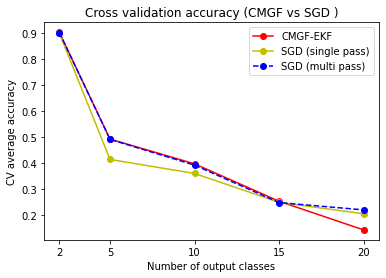

In [22]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'ro-', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'yo-', label='SGD (single pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--o', label='SGD (multi pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel('CV average accuracy')
ax.set_title('Cross validation accuracy (CMGF vs SGD )')
ax.legend();

## Speed Comparison with SGD

In [29]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000)) \
                 + list(range(10000, 100000, 10000)) + list(range(100000, 1000000, 100000))


data_size_grid = [100, 1000, 10_000, 100_000, 200_000, 500_000]



In [30]:
cmgf_est = CMGFEstimator()
sgd_op_est = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
sgd_mp_est = LogisticRegression(multi_class='multinomial', solver='sag')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 100
cmgf took 0.9645509719848633 seconds.
one-pass sgd took 0.0018000602722167969 seconds.
multi-pass sgd took 0.002279996871948242 seconds.
dataset of size 1000
cmgf took 1.0108699798583984 seconds.
one-pass sgd took 0.002340078353881836 seconds.
multi-pass sgd took 0.0076007843017578125 seconds.
dataset of size 10000
cmgf took 1.197556972503662 seconds.
one-pass sgd took 0.006684064865112305 seconds.
multi-pass sgd took 0.07934999465942383 seconds.
dataset of size 100000
cmgf took 2.401423931121826 seconds.
one-pass sgd took 0.06981801986694336 seconds.
multi-pass sgd took 1.3323872089385986 seconds.
dataset of size 200000
cmgf took 3.434422731399536 seconds.
one-pass sgd took 0.16901516914367676 seconds.
multi-pass sgd took 2.907855987548828 seconds.
dataset of size 500000
cmgf took 8.769384145736694 seconds.
one-pass sgd took 0.4990231990814209 seconds.
multi-pass sgd took 7.493085145950317 seconds.


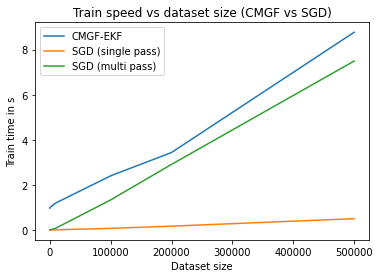

In [31]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

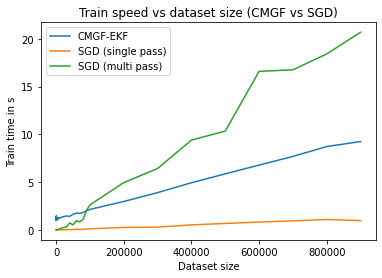

In [ ]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

##4. (K-1) CMGF Binary Regressions

Let us try to construct the multinomial logistic regression as a combination of $(K-1)$ binary logistic regressions.

In [32]:
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

class CMGFOneVsAllEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self,  weights=None):
        self.weights = weights

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        input_dim = X_bias.shape[-1]
        num_classes = y.max() + 1

        # Construct CMGFParams
        cmgf_params = ParamsGGSSM(
            initial_mean = jnp.zeros(input_dim),
            initial_covariance = jnp.eye(input_dim),
            dynamics_function = lambda w, x: w,
            dynamics_covariance = jnp.zeros((input_dim, input_dim)),
            emission_mean_function = sigmoid_fn,
            emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
        )

        # Construct (K-1) binary classifiers
        classifiers = []
        for k in range(num_classes):
            y_k = jnp.array((y == k).astype(float))
            post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), y_k, inputs=X_bias)
            classifiers.append(post.filtered_means[-1])

        self.weights = jnp.array(classifiers)
        return self
    
    def predict(self, X, y=None):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jnp.argmax(sigmoid_fn(X_bias, self.weights.T), axis=1)

Let's examine the speed-up.

In [33]:
cmgf_est = CMGFOneVsAllEstimator()
sgd_op_est = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
sgd_mp_est = LogisticRegression(multi_class='multinomial', solver='sag')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

data_size_grid = [100, 1000, 10_000, 100_000]

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 100
cmgf took 2.0326571464538574 seconds.
one-pass sgd took 0.0015327930450439453 seconds.
multi-pass sgd took 0.002624034881591797 seconds.
dataset of size 1000
cmgf took 1.882213830947876 seconds.
one-pass sgd took 0.002178192138671875 seconds.
multi-pass sgd took 0.006849050521850586 seconds.
dataset of size 10000
cmgf took 2.1869912147521973 seconds.
one-pass sgd took 0.007147073745727539 seconds.
multi-pass sgd took 0.08160614967346191 seconds.
dataset of size 100000
cmgf took 3.370532989501953 seconds.
one-pass sgd took 0.06386518478393555 seconds.
multi-pass sgd took 0.9704718589782715 seconds.


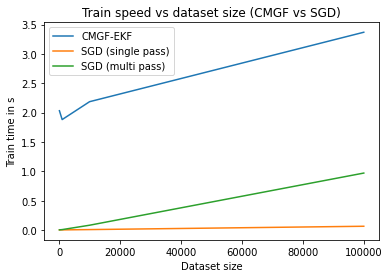

In [34]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

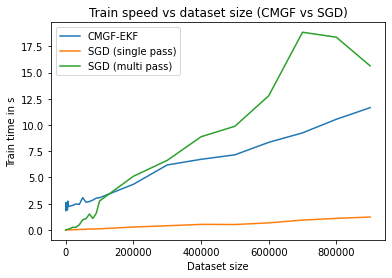

In [ ]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

In [35]:
def compute_cv_accuracies(num_points, num_classes):
    input, output = make_classification(n_samples=num_points, n_features=num_classes+1, 
                                        n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=2)
    scaler = preprocessing.StandardScaler().fit(input)
    input, output = jnp.array(scaler.transform(input)), jnp.array(output)

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

    cmgf_est = CMGFOneVsAllEstimator()

    cmgf_score = cross_val_score(cmgf_est, input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_op_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_mp_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag'), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()

    return cmgf_score, sag_op_score, sag_mp_score

In [36]:
num_points = 1000
class_range = range(2, 19)
class_range = [2, 5, 10, 15, 20]

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    cmgf_ac, sgd_op_ac, sgd_mp_ac = compute_cv_accuracies(num_points, num_classes)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sag estimate average accuracy = {sgd_op_ac}')
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sag estimate average accuracy = {sgd_mp_ac}')

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.902998807190424
One-pass sag estimate average accuracy = 0.892994791198384
Multi-pass sag estimate average accuracy = 0.9019978061894229
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.49599000197802595
One-pass sag estimate average accuracy = 0.4100207992423561
Multi-pass sag estimate average accuracy = 0.49099698500896105
1000 data points, 10 classes.
EKF-CMGF estimate average accuracy = 0.3980057902213591
One-pass sag estimate average accuracy = 0.37199175223127323
Multi-pass sag estimate average accuracy = 0.39199978421535303
1000 data points, 15 classes.
EKF-CMGF estimate average accuracy = 0.256960553367739
One-pass sag estimate average accuracy = 0.23797150443857026
Multi-pass sag estimate average accuracy = 0.24796652940365518
1000 data points, 20 classes.
EKF-CMGF estimate average accuracy = 0.22398746051440663
One-pass sag estimate average accuracy = 0.18500836165506826
Multi-pass sag esti

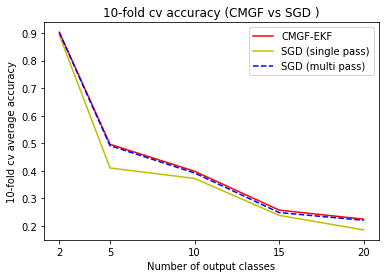

In [37]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel('10-fold cv average accuracy')
ax.set_title('10-fold cv accuracy (CMGF vs SGD )')
ax.legend();